## Proyecto Final Redes Neuronales

- Martínez Cano Ricardo Iván 
- Victoria Morales Ricardo Maximiliano

In [19]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import random
import glob
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision as tv
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader    
from torchvision import transforms
from PIL import Image
import torch


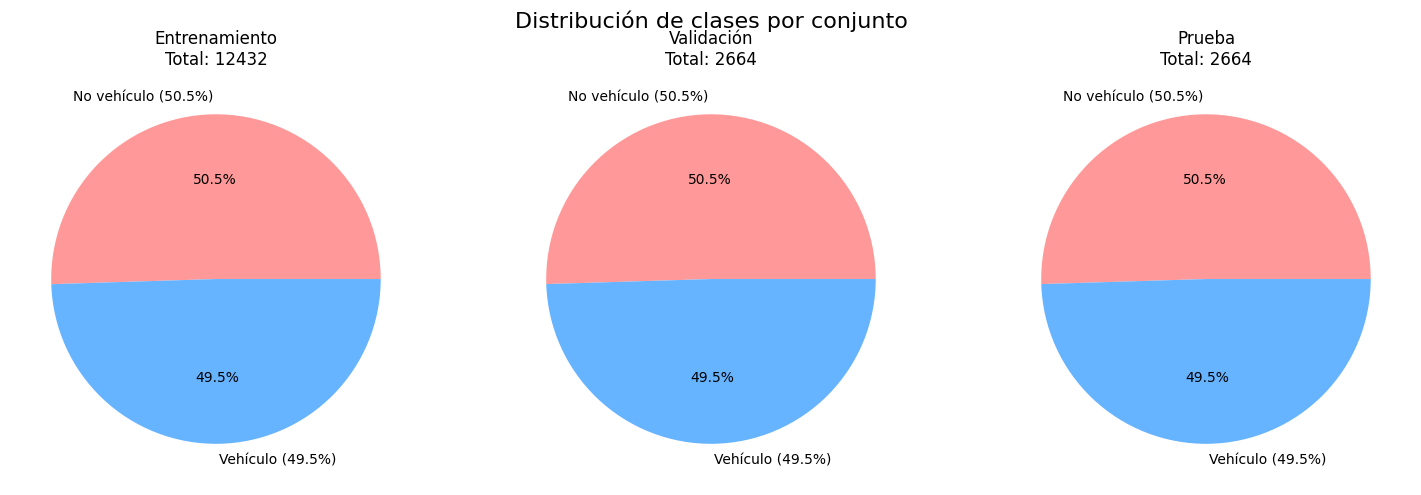

In [26]:
import matplotlib.pyplot as plt
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import numpy as np
from sklearn.model_selection import train_test_split
import os

# 1. Transformaciones
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
])

# 2. Cargar dataset
dataset = datasets.ImageFolder(root='data', transform=transform)
targets = np.array([label for _, label in dataset.samples])  # 0 o 1

# 3. División estratificada
train_idx, temp_idx = train_test_split(
    np.arange(len(targets)), test_size=0.3, stratify=targets, random_state=42
)
val_idx, test_idx = train_test_split(
    temp_idx, test_size=0.5, stratify=targets[temp_idx], random_state=42
)

# 4. Guardar índices
os.makedirs("splits", exist_ok=True)
np.save("splits/train_idx.npy", train_idx)
np.save("splits/val_idx.npy", val_idx)
np.save("splits/test_idx.npy", test_idx)

# 5. Subsets y DataLoaders
train_dataset = Subset(dataset, train_idx)
val_dataset = Subset(dataset, val_idx)
test_dataset = Subset(dataset, test_idx)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# 6. Función de balance
def obtener_balance(loader):
    counts = torch.zeros(2)
    for _, labels in loader:
        for label in labels:
            counts[label.item()] += 1
    total = counts.sum().item()
    porcentajes = 100.0 * counts / total
    return counts.tolist(), porcentajes.tolist(), int(total)

# 7. Preparar visualización
clases = ['No vehículo', 'Vehículo']
conjuntos = ['Entrenamiento', 'Validación', 'Prueba']
loaders = [train_loader, val_loader, test_loader]
os.makedirs("plots", exist_ok=True)

# 8. Gráficas individuales con conteo total
for loader, nombre in zip(loaders, conjuntos):
    cuentas, porcentajes, total = obtener_balance(loader)
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.pie(cuentas, labels=[f"{clases[j]} ({porcentajes[j]:.1f}%)" for j in range(2)],
           autopct='%1.1f%%', colors=['#ff9999','#66b3ff'])
    ax.set_title(f"Distribución de clases - {nombre}")
    plt.suptitle(f"Total de imágenes: {total}", fontsize=10)
    plt.savefig(f"plots/{nombre.lower()}_distribution.png")
    plt.close()

# 9. Figura combinada con conteos
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i, loader in enumerate(loaders):
    cuentas, porcentajes, total = obtener_balance(loader)
    axes[i].pie(cuentas, labels=[f"{clases[j]} ({porcentajes[j]:.1f}%)" for j in range(2)],
                autopct='%1.1f%%', colors=['#ff9999','#66b3ff'])
    axes[i].set_title(f"{conjuntos[i]}\nTotal: {total}")

plt.suptitle("Distribución de clases por conjunto", fontsize=16)
plt.tight_layout()
plt.savefig("plots/combined_distribution.png")
plt.show()


In [27]:
# Iterar sobre batches (x: imágenes, y: etiquetas)
for x, y in train_loader:
    print(x.shape)  # (32, 3, 64, 64)
    print(y.shape)  # (32,)
    print(y)        # Tensores con 0 o 1 según la clase
    break  # Solo para ver un batch

torch.Size([32, 3, 64, 64])
torch.Size([32])
tensor([1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1,
        0, 0, 1, 1, 0, 0, 0, 1])


### Intento 1

In [ ]:
while True:
    pass

In [17]:
# Obtener directorios de datos
vehicle_dir = os.path.join(os.getcwd(), 'data', 'vehicles')
non_vehicle_dir = os.path.join(os.getcwd(), 'data', 'non-vehicles')

# Verificar si los directorios existen
if not os.path.exists(vehicle_dir):
    raise FileNotFoundError(f"Vehicle images directory does not exist: {vehicle_dir}")
if not os.path.exists(non_vehicle_dir):
    raise FileNotFoundError(f"Non-vehicle images directory does not exist: {non_vehicle_dir}")

In [20]:
# Transformación a tensor (normaliza a [0,1] y pone canales primero: CxHxW)
transform = transforms.Compose([
    transforms.Resize((64, 64)),       # Asegura tamaño 64x64
    transforms.ToTensor(),             # Convierte a tensor con shape (3, 64, 64)
])

# Ruta a tu carpeta de imágenes
folder_path = vehicle_dir
image_files = [f for f in os.listdir(folder_path) if f.endswith(('.png', '.jpg', '.jpeg'))]

# Cargar imágenes
images = []
for file in image_files:
    img = Image.open(os.path.join(folder_path, file)).convert('RGB')
    img_tensor = transform(img)
    images.append(img_tensor)

# Stack para obtener un tensor de 4 dimensiones: (batch_size, 3, 64, 64)
batch_tensor = torch.stack(images)  # Tensor final

print(batch_tensor.shape)  # e.g., torch.Size([10, 3, 64, 64])


torch.Size([8792, 3, 64, 64])


In [24]:
print(image_files[:5])

['1.png', '10.png', '1000.png', '1001.png', '1002.png']


In [21]:
print(batch_tensor[0])

tensor([[[0.1333, 0.1294, 0.1294,  ..., 0.3608, 0.4627, 0.5686],
         [0.1529, 0.1490, 0.1451,  ..., 0.3569, 0.4627, 0.5765],
         [0.1686, 0.1647, 0.1569,  ..., 0.3569, 0.4745, 0.5961],
         ...,
         [0.9961, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [0.9882, 0.9961, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [0.9843, 0.9922, 1.0000,  ..., 1.0000, 1.0000, 1.0000]],

        [[0.1412, 0.1373, 0.1294,  ..., 0.4314, 0.4392, 0.4431],
         [0.1529, 0.1569, 0.1529,  ..., 0.4235, 0.4941, 0.5725],
         [0.1647, 0.1725, 0.1686,  ..., 0.4235, 0.5569, 0.6980],
         ...,
         [0.9647, 0.9490, 0.9412,  ..., 1.0000, 1.0000, 1.0000],
         [0.9686, 0.9608, 0.9529,  ..., 1.0000, 1.0000, 1.0000],
         [0.9843, 0.9804, 0.9765,  ..., 1.0000, 1.0000, 1.0000]],

        [[0.1647, 0.1647, 0.1569,  ..., 0.4824, 0.4745, 0.4706],
         [0.1686, 0.1725, 0.1725,  ..., 0.4980, 0.5020, 0.5059],
         [0.1725, 0.1882, 0.1882,  ..., 0.5059, 0.5098, 0.

### Red Neuronal

In [ ]:
class CNN(nn.Module): 
    def __init__(self): 
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(32 * 3 * 3, 384)
        self.fc2 = nn.Linear(384, 192)
        self.fc3 = nn.Linear(192, 2)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, kernel_size=2, stride=2)

        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, kernel_size=2, stride=2)

        x = x.view(-1, 32 * 3 * 3)  

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return x
    
    def train(self, epochs, data_loader, criterion, optimizer, cuda = False):
        losses = []
        for epoch in epochs: 
            running_loss = 0.0
            for i, data in enumerate(data_loader, 0): 
                if(cuda and torch.cuda.is_available()): 
                    inputs, labels = inputs.cuda(), labels.cuda()
                
                optimizer.zero_grad()
                outputs = self(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                running_loss += loss.item()

            epoch_loss = running_loss / len(data_loader)
            losses.append(epoch_loss)
            print(f'Ciclo {epoch+1}/{len(epochs)}, Perdida: {epoch_loss:.4f}')

        plt.plot(epochs, losses, label='Perdida durante el entrenamiento')
        plt.grid()
        plt.xlabel('Ciclos')
        plt.ylabel('Perdida')
        plt.title('Perdida durante el entrenamiento')
        plt.show()
        plt.legend()

        return losses
